In [1]:
from scripts import train
from openunmix import our_data, model, utils
import importlib
import torch
import torchaudio

import matplotlib.pyplot as plt

In [2]:
importlib.reload(train)
importlib.reload(model)
importlib.reload(our_data)

<module 'openunmix.our_data' from '/home/jovyan/lign-168-open-unmix-pytorch/openunmix/our_data.py'>

In [ ]:
train.main()

Using GPU: True


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Training batch:  20%|██        | 1/5 [01:05<04:21, 65.46s/it, loss=2.668]

In [52]:
dataset = our_data.ESMUC_Dataset_Isolated("~/ESMUC_dataset", split='valid')


In [53]:

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

target = "vocals"
unmix = utils.load_target_models(
            target, model_str_or_path="open-unmix", device=device, pretrained=True
        )[target]
print(unmix)
unmix = unmix.to(device)

separator = model.Separator({'vocals': unmix}, 0, nb_channels = 1).to(device)


OpenUnmix(
  (fc1): Linear(in_features=1487, out_features=512, bias=False)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(512, 256, num_layers=3, dropout=0.4, bidirectional=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=False)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=512, out_features=2049, bias=False)
  (bn3): BatchNorm1d(2049, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [78]:

def plot_spectrogram(stft, title="Spectrogram"):
    magnitude = stft.abs()
    spectrogram = 20 * torch.log10(magnitude + 1e-8).numpy()
    _, axis = plt.subplots(1, 1)
    axis.imshow(spectrogram, cmap="viridis", vmin=-60, vmax=-10, origin="lower", aspect="auto")
    axis.set_title(title)
    plt.tight_layout()


x, y_corr = dataset[0]
print(x)
y = separator.forward(x.to(device).unsqueeze(0))

print(x, y, y_corr)

# plot_spectrogram(estimates[:, 0, 0, :].reshape(8000, 1).detach())
# plot_spectrogram(estimates[:, 1, 0, :].reshape(8000, 1).detach())


tensor([[ 9.8695e-08,  7.8311e-08,  2.7966e-07,  ..., -6.3113e-02,
         -7.1152e-02, -7.9391e-02]])
tensor([[ 9.8695e-08,  7.8311e-08,  2.7966e-07,  ..., -6.3113e-02,
         -7.1152e-02, -7.9391e-02]]) tensor([[[[-0.0004, -0.0004, -0.0004,  ..., -0.0316, -0.0417, -0.0504]]]],
       device='cuda:0', grad_fn=<ViewBackward0>) tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.1319, -0.1397, -0.1484]])


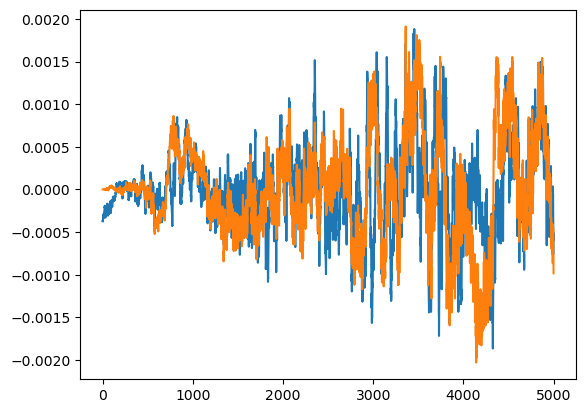

In [79]:
plt.plot(y.squeeze([0, 1, 2]).detach().to('cpu').numpy()[0:5000])
plt.plot(y_corr.squeeze(0)[0:5000])

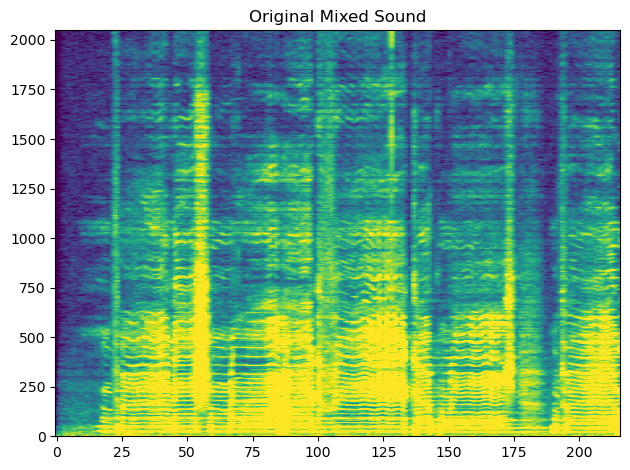

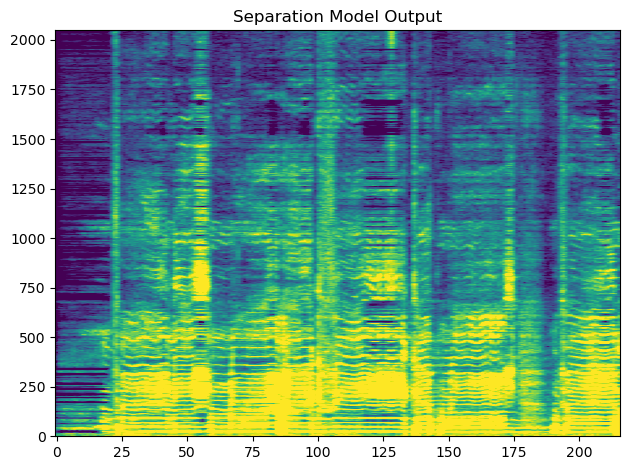

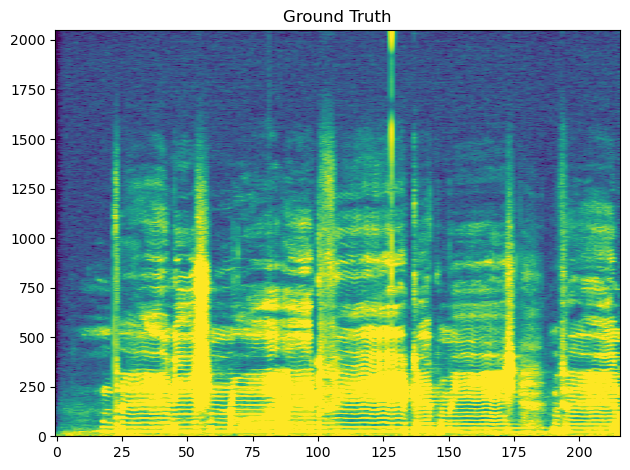

In [80]:
stft = torchaudio.transforms.Spectrogram(
    n_fft=4096,
    hop_length=1024,
    power=None,
).to(device)


plot_spectrogram(stft(x.to(device).squeeze(0).detach()).cpu(), "Original Mixed Sound")
plot_spectrogram(stft(y.squeeze([0, 1, 2]).detach()).cpu(), "Separation Model Output")
plot_spectrogram(stft(y_corr.to(device).squeeze(0)).cpu(), "Ground Truth")

In [82]:
from IPython.display import Audio
print("Mixed Signal")
Audio(data=x, rate=dataset.sample_rate)



Mixed Signal


In [83]:
print("Model Output")
Audio(data=y.squeeze([0, 1, 2]).detach().cpu(), rate=dataset.sample_rate)

Model Output


In [85]:
print("Ground Truth")
Audio(data=y_corr, rate=dataset.sample_rate)

Ground Truth
